In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_combrf
import matplotlib.pyplot as plt

import numpy as np

In [3]:
env = gym.make('combrf-v7')

In [4]:
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

beamset = Generate_Beams(8,np.array([np.pi/8, np.pi/4]))

print(beamset)

[(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)
 (0.78539816, 4) (1.57079633, 4) (2.35619449, 4) (3.14159265, 4)]


In [5]:

obs = env.reset(np.exp(1j * 2 * np.pi * 0.6))
#print(obs)
#print(obs.shape)
print(env.ch_model)
print(env.tx_loc)
print(env.obs_space.sample())
print(env.rx_xcov)

uma-los
[[-100.     0.    21.5]]
[0 0 0 2]
[-100    0]


In [6]:
#Testing the max possible reward
from Source.antenna import ula
from Source.misc_fun.geometry import cart2sph
from Source.misc_fun.conversion import *

def compute_rate(r, theta, txbdir_ndx, wRF):
    tx_loc = np.array([[r*np.cos(theta), r*np.sin(theta), 22.5]])
    sc_xyz = np.array([])

    obs = env.test_reset(tx_loc, txbdir_ndx, sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    #print(env.h)
    tx = env.tx_loc
    rx = env.rx_loc
    (az_aoa, el_aoa, temp) = cart2sph(tx[0, 0] - rx[0, 0], tx[0, 1] -rx[0, 1], tx[0, 2] - rx[0, 2])
    
    #self.tx_beam = ula.var_steervec(self.N_tx, self.tx_bdir, 0)
    #self.eff_ch = np.array(self.h[:, :, 0]).dot(self.tx_beam)
    #print("eff_ch: ", env.eff_ch)
    rssi_val = np.sqrt(env.N_rx * env.N_tx) * np.array(np.conj(wRF.T).dot(env.eff_ch)) #+ (np.conj(wRF.T).dot(env.noise))[0]
    
    #next_obs, rwd, done, _ = env.step(rxbdir_ndx)
    #print(rssi_val)
    #print((np.conj(wRF.T).dot(env.noise))[0])
    Es = db2lin(env.P_tx) #* (1e-3 / self.B)
    SNR = Es * np.abs(rssi_val)**2 / (env.N0*env.B)
    rate = np.log2(1 + SNR)  # in Gbit/s (self.B / self.nFFT) *
    return rssi_val, rate
#As the max reward is close to 1, calculation of reward based on reward seems to be good, 
#especially with random tx_beam and additional noise

In [26]:
#best narrow beam
r1 = 1
theta1 = 0*np.pi/180
txbdir_ndx1 = 0
rxbdir_ndx1 = 7
_,rate1 = compute_rate(r1, theta1,txbdir_ndx1, rxbdir_ndx1)
print("txloc: ", np.array([[r1*np.cos(theta1), r1*np.sin(theta1), 0]]))
print("narrow beam rate1: ", rate1)
print("rxbeam: ",(env.BeamSet[rxbdir_ndx1][0]*180/np.pi,env.BeamSet[rxbdir_ndx1][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx1] , 0))
#best wide beam
r2 = 1
theta2 = 0*np.pi/180
txbdir_ndx2 = 0
rxbdir_ndx2 = 11
_,rate2 = compute_rate(r2, theta2,txbdir_ndx2, rxbdir_ndx2)
print("txloc: ", np.array([[r2*np.cos(theta2), r2*np.sin(theta2), 0]]))
print("wide beam rate2: ", rate2)
print("rxbeam: ",(env.BeamSet[rxbdir_ndx2][0]*180/np.pi,env.BeamSet[rxbdir_ndx2][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx2] , 0))

theta_1, gr_1 = var_plotbeam(env.BeamSet[rxbdir_ndx1], 8)
theta_2, gr_2 = var_plotbeam(env.BeamSet[rxbdir_ndx2],4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta_1, gr_1, theta_2, gr_2)
#plt.pause(0.001)
ax.scatter(theta1, r1, c='r')
plt.show()

AttributeError: 'int' object has no attribute 'T'

txloc:  [[70.71067812 70.71067812  0.        ]]
narrow beam rate1:  19.003618936427667
rxbeam:  (45.0, 8)
codeword:  [ 0.35355339+0.j         -0.21414724+0.28132003j -0.09413548-0.34079101j
  0.32818294+0.13151411j -0.30342524+0.18147485j  0.03938632-0.3513527j
  0.25571266+0.24415371j -0.34915657+0.05558496j]
txloc:  [[70.71067812 70.71067812  0.        ]]
wide beam rate2:  17.0036299492855
rxbeam:  (45.0, 4)
codeword:  [ 0.35355339+0.j         -0.21414724+0.28132003j -0.09413548-0.34079101j
  0.32818294+0.13151411j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]


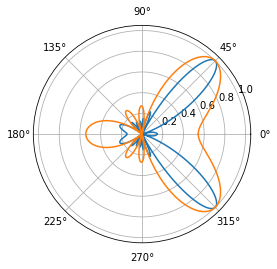

In [8]:
#worst narrow beam
r1 = 100
theta1 = 45*np.pi/180
txbdir_ndx1 = 0
rxbdir_ndx1 = 1
wRF = ula.var_steervec(env.N_rx, (env.BeamSet[rxbdir_ndx1][0]-0*np.pi/180,env.BeamSet[rxbdir_ndx1][1]), 0)
_,rate1 = compute_rate(r1, theta1,txbdir_ndx1, wRF)
print("txloc: ", np.array([[r1*np.cos(theta1), r1*np.sin(theta1), 0]]))
print("narrow beam rate1: ", rate1)
print("rxbeam: ",((env.BeamSet[rxbdir_ndx1][0]-0*np.pi/180)*180/np.pi,env.BeamSet[rxbdir_ndx1][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx1] , 0))

#best wide beam
r2 = 100
theta2 = 45*np.pi/180
txbdir_ndx2 = 0
rxbdir_ndx2 = 8
wRF = ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx2], 0)
_,rate2 = compute_rate(r2, theta2,txbdir_ndx2, wRF)
print("txloc: ", np.array([[r2*np.cos(theta2), r2*np.sin(theta2), 0]]))
print("wide beam rate2: ", rate2)
print("rxbeam: ",(env.BeamSet[rxbdir_ndx2][0]*180/np.pi,env.BeamSet[rxbdir_ndx2][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx2] , 0))

theta_1, gr_1 = var_plotbeam(env.BeamSet[rxbdir_ndx1], 8)
theta_2, gr_2 = var_plotbeam(env.BeamSet[rxbdir_ndx2],4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta_1, gr_1, theta_2, gr_2)
#plt.pause(0.001)
#ax.scatter(theta1, r1, c='r')
plt.show()

[0.39 0.79 1.18 1.57 1.96 2.36 2.75 3.14]


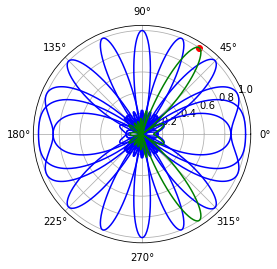

In [44]:
from Source.misc_fun.utils import Generate_BeamDirs, plotbeam
import numpy as np
r=1
beamset = Generate_BeamDirs(8,np.array([0]))
print(beamset)

ax = plt.subplot(111, projection='polar')
for i in range(len(beamset)):
    
    theta, gr = plotbeam(beamset[i],8)
    ax.plot(theta, gr, color='blue')

theta, gr = plotbeam(beamset[1]+11.25*np.pi/180,8)
ax.plot(theta, gr, color='green')

ax.scatter(beamset[1]+11.25*np.pi/180, r, c='r')
#plt.savefig("ploar_withrefinement.png")
plt.show()

In [12]:
#worst narrow beam
r1 = 1
theta1 = 67.5*np.pi/180
txbdir_ndx1 = 0
rxbdir_ndx1 = 3
_,rate1 = compute_rate(r1, theta1,txbdir_ndx1, rxbdir_ndx1)
print("txloc: ", np.array([[r1*np.cos(theta1), r1*np.sin(theta1), 21.5]]))
print("narrow beam rate1: ", rate1)
print("rxbeam: ",(env.BeamSet[rxbdir_ndx1][0]*180/np.pi,env.BeamSet[rxbdir_ndx1][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx1] , 0))

#worst wide beam
r2 = 1
theta2 = 67.5*np.pi/180
txbdir_ndx2 = 0
rxbdir_ndx2 = 9
_,rate2 = compute_rate(r2, theta2,txbdir_ndx2, rxbdir_ndx2)
print("txloc: ", np.array([[r2*np.cos(theta2), r2*np.sin(theta2), 0]]))
print("wide beam rate2: ", rate2)
print("rxbeam: ",(env.BeamSet[rxbdir_ndx2][0]*180/np.pi,env.BeamSet[rxbdir_ndx2][1]))
print("codeword: ", ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx2] , 0))

theta_1, gr_1 = var_plotbeam(env.BeamSet[rxbdir_ndx1], 8)
theta_2, gr_2 = var_plotbeam(env.BeamSet[rxbdir_ndx2],4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta_1, gr_1, theta_2, gr_2)
#plt.pause(0.001)
ax.scatter(theta1, r1, c='r')
plt.show()

AttributeError: 'int' object has no attribute 'T'

(0.39269908, 8)
(0.78539816, 8)
(1.17809725, 8)
(1.57079633, 8)
(1.96349541, 8)
(2.35619449, 8)
(2.74889357, 8)
(3.14159265, 8)
(0.78539816, 4)
(1.57079633, 4)
(2.35619449, 4)
(3.14159265, 4)


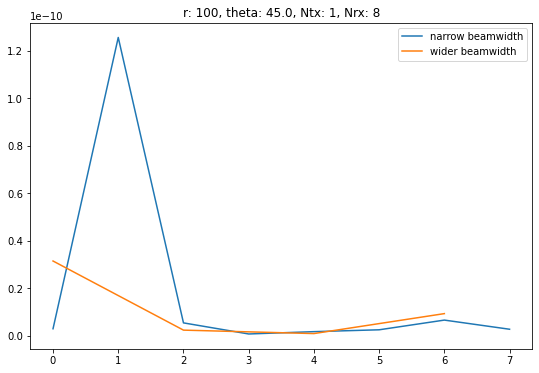

In [16]:
r2 = 100
theta2 = 45*np.pi/180
txbdir_ndx2 = 0

#rxbdir_ndx2 = 9
rss_vals=[]
rate_vals=[]
widerss_vals=[]
widerate_vals =[]
for rxbdir_ndx in range(len(env.BeamSet)):
    print(env.BeamSet[rxbdir_ndx])
    wRF = ula.var_steervec(env.N_rx, env.BeamSet[rxbdir_ndx], 0)
    rssi_val,rate = compute_rate(r2, theta2,txbdir_ndx2, wRF)
    #print(rssi_val)
    if(rxbdir_ndx <=7):
    #    if (rxbdir_ndx == 1):
    #        print(wRF)
    #        print([x*2.78/y for x,y in zip(wRF, env.eff_ch)])
        rss_vals.append(np.abs(rssi_val)**2)
        rate_vals.append(rate)
    else:
    #    if (rxbdir_ndx == 8):
    #        print(env.BeamSet[rxbdir_ndx])
    #        print(rate)
    #        print(np.abs(rssi_val)**2)
    #        print(wRF)
    #        print([x/y for x,y in zip(wRF, env.eff_ch)])
        widerss_vals.append(np.abs(rssi_val)**2)
        widerate_vals.append(rate)
        
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(len(rss_vals)), rss_vals, np.arange(0,len(rss_vals),2), widerss_vals)
plt.legend(["narrow beamwidth", "wider beamwidth"])
plt.title("r: {}, theta: {}, Ntx: {}, Nrx: {}".format(r2, theta2*180/np.pi, env.N_tx, env.N_rx))
plt.show()

best narrow beam rate: 19.003618936427667, best wider beam rate: 17.0036299492855


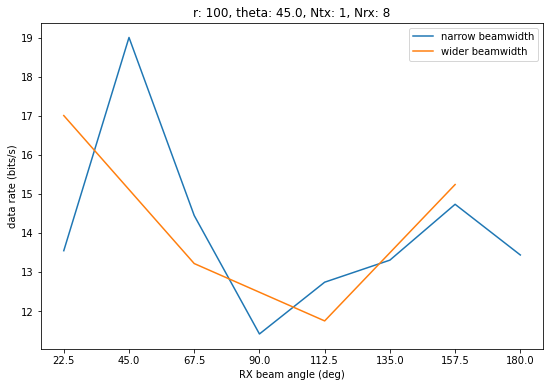

In [19]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(len(rate_vals)), rate_vals, np.arange(0,len(rate_vals),2), widerate_vals)
print("best narrow beam rate: {}, best wider beam rate: {}".format(max(rate_vals), max(widerate_vals)))
plt.legend(["narrow beamwidth", "wider beamwidth"])
plt.xticks(np.arange(0, len(rate_vals)), [str(np.round(x[0]*180/np.pi, decimals=2)) for x in env.BeamSet[0:len(rate_vals)]])
plt.xlabel('RX beam angle (deg)')
plt.ylabel('data rate (bits/s)')
plt.title("r: {}, theta: {}, Ntx: {}, Nrx: {}".format(r2, theta2*180/np.pi, env.N_tx, env.N_rx))
#plt.savefig("140820_wide_narrow_rate_2.pdf")
plt.show()

In [5]:
obs = env.reset()
#print(obs)
print("cap: ", env.get_capacity())
print("TX loc: ", env.tx_loc)
i=0
while True:
    action = env.action_space.sample()
    obs, rwd, done, _ = env.step(action)
    #if (i==0):
    #    print(obs)
    #    i+=1
    print(action, rwd, env.rate)
    
    if done:
        break

cap:  63.20122720374464
TX loc:  [[5 5 0]]
1 1.0 24.921197795269865
7 0.0 19.474026682266594
2 0.0 19.784164261454205
2 0.0 19.784164261454205
7 0.0 19.474026682266594
4 0.0 18.9690924079018
6 0.0 20.688128360888456
5 0.0 19.343283062822444
7 0.0 19.474026682266594


In [24]:
sc = np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0]])
obs = env.test_reset(np.array([[100,0,0]]), 2, sc)
print(env.tx_loc)
print(env.tx_bdir*(180/np.pi))
print(env.rx_bdir*(180/np.pi))
rate, ndx, rssi_val = env.get_exh_rate()
print(rssi_val)
print(rate)
print(env.channel.pathloss)

[[100   0   0]]
67.5
180.0
(5.641096401206994e-07+2.563267528998267e-06j)
14.815773595650851
[113.14242509 125.77402271 119.32562882 119.60381232 122.47205674]


In [25]:
tx_loc = np.array([[100,0,0]])
sc = np.array([[0,100,0]])

best_rssi_val = 0
best_rate = 0.0
best_rx_ndx = 0
best_tx_ndx = 0
for tx_ndx in range(env.N_tx):
    obs = env.test_reset(tx_loc, tx_ndx, sc)
    rate, rx_ndx, rssi_val = env.get_exh_rate()
    if (rate > best_rate):
        best_rate = rate
        best_rssi_val = rssi_val
        best_rx_ndx = rx_ndx
        best_tx_ndx = tx_ndx    

print(tx_loc)
print("TX bdir: ", env.BeamSet[best_tx_ndx]*(180/np.pi))
print("RX bdir: ", env.BeamSet[best_rx_ndx]*(180/np.pi))
print(best_rssi_val)
        

[[100   0   0]]
TX bdir:  135.0
RX bdir:  90.0
(-5.444413426840645e-06+1.67561815733637e-05j)


[2.2323250642816386e-10, 1.0100815027369333e-11, 4.9231008823479455e-12, 1.0970438530185917e-11, 9.004795240891989e-12, 7.83437581773722e-12, 2.3647965192217127e-10, 3.156091516258566e-10]
[2.2775273136418877e-10, 1.7084668732487872e-10, 1.6324998827237085e-10, 1.9521882370801835e-11, 7.030036500291732e-12, 6.311452959775423e-12, 5.19186220812554e-12, 4.8711536905300006e-12]
[7, 6, 0, 3, 4, 1, 5, 2]


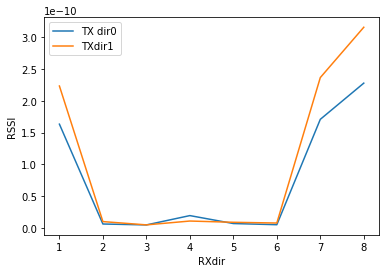

In [26]:
#Plot the curves for RSSI vs rx bdir for two different tx_directions

tx_loc = np.array([[100,0,0]])
sc = np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0]])

obs_1 = env.test_reset(tx_loc, 0, sc)
rssi_values1, rate_values1 = env.meas_rate()
rssi_values1 = [np.abs(x) ** 2 for x in rssi_values1]
yaxis1 = list(reversed(np.sort(rssi_values1)))

obs_2 = env.test_reset(tx_loc, 7, sc)
rssi_values2, rate_values2 = env.meas_rate()
rssi_values2 = [np.abs(x) ** 2 for x in rssi_values2]
print(rssi_values2)
yaxis2 = list(reversed(np.sort(rssi_values2)))

fig = plt.figure()
#ax1 = fig.add_subplot(131)
xaxis1 = []
for val in yaxis1:
    ndx = rssi_values1.index(val)
    xaxis1.append(ndx)
    
xaxis2 = []
for val in yaxis2:
    ndx = rssi_values2.index(val)
    xaxis2.append(ndx)

print(yaxis1)
print(xaxis1)

#plt.plot(xaxis1, yaxis1,xaxis2, yaxis2 )
plt.plot(np.arange(1, env.N_tx+1), rssi_values1,np.arange(1, env.N_tx+1), rssi_values2 )

plt.ylabel('RSSI')
plt.xlabel('RXdir')
plt.legend(['TX dir0', 'TXdir1'])
plt.show()
